# 1.0 Imports

In [ ]:
import os
import warnings
import pandas as pd
import math
import numpy as np
import datetime
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate
from boruta import BorutaPy
from pathlib import Path

from IPython.core.display import HTML
from IPython.display import Image

from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split, BaseCrossValidator
from skopt import BayesSearchCV, space 

## 0.1. Helper functions

In [ ]:
# Define function to calculate cramer v 
def cramerv(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chis2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chis2corr/n) / min(kcorr-1, rcorr-1))

def mean_absolute_percentage_error(y, yhat):
    return  np.mean( np.abs( (y - yhat) / y ) )

def mean_percentage_error(y, yhat):
    return  np.mean((y - yhat) / y)


def ml_error (model_name: str, y: pd.Series, yhat: pd.Series) -> pd.DataFrame:
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_absolute_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])    

def cross_val(model, kfold, x_training):
    mae_list = []
    mape_list = []
    rmse_list = []

    print(f'Model in Trainning: {model.__class__.__name__}')

    # Creating the cross validation folds
    for k in reversed(range(1, kfold+1)):
        print(f'Kfold: {k}')

        start_lim = x_training['date'].max() - datetime.timedelta(k*6*7)      # We decide early that the window to split the data in tranning and test will use units of 6 weeks. 
        end_lim = x_training['date'].max() - datetime.timedelta((k-1)*6*7)

        # Filtering dataframe
        trainning = x_training[x_training['date'] < start_lim]
        validation = x_training[(x_training['date'] >= start_lim) & (x_training['date'] <= end_lim)] 

        # Cross validation datasets (just removing the date and sales columns again, since this columns will not be used on tranning)
        xtrainning = trainning.drop(columns=['date', 'sales'], axis = 1)
        ytrainning = trainning['sales']

        xvalidation = validation.drop(columns=['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # Model tranning 
        m = model.fit(xtrainning, ytrainning)
        yhat = m.predict(xvalidation)

        # Performance
        results = ml_error(model.__class__.__name__, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(results['MAE'])
        mape_list.append(results['MAPE'])
        rmse_list.append(results['RMSE'])

    print('---------------------------------------------')

    return pd.DataFrame({'Model Name': model.__class__.__name__ ,
                         'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str),
                         }, index = [0])

class TimeSeriesWindowSplit(BaseCrossValidator):
    """
    CV temporal com janelas fixas retroativas (ex.: 6 semanas).
    Use .fit(X, y, groups=dates) — 'dates' é um vetor de datas (len == len(X) == len(y)).
    """
    def __init__(self, n_splits=5, window_weeks=6, drop_empty=True):
        self.n_splits = n_splits
        self.window_weeks = window_weeks
        self.drop_empty = drop_empty

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("Passe as datas via 'groups' em .fit(X, y, groups=dates).")

        # Converte para Series de datetime e cria índices POSICIONAIS 0..n-1
        dates = pd.to_datetime(pd.Series(groups)).reset_index(drop=True)
        n = len(dates)
        idx = np.arange(n)

        end_date = dates.max()
        window = datetime.timedelta(weeks=self.window_weeks)

        produced = 0
        # Gera n_splits janelas de trás pra frente (cada uma com 'window_weeks')
        for k in range(self.n_splits, 0, -1):
            start = end_date - k * window
            end   = end_date - (k - 1) * window

            mask_val   = (dates >= start) & (dates <= end)
            mask_train = (dates < start)

            train_idx = idx[mask_train.to_numpy()]
            val_idx   = idx[mask_val.to_numpy()]

            if (len(train_idx) == 0 or len(val_idx) == 0):
                print(f"⚠️ Split {k} descartado (train={len(train_idx)}, test={len(val_idx)})")
                if self.drop_empty:
                    continue
                else:
                    raise ValueError(
                        f"Fold vazio em k={k}: train={len(train_idx)}, val={len(val_idx)} "
                        f"(janela {start.date()}..{end.date()}). Ajuste n_splits/window."
                    )

            produced += 1
            yield train_idx, val_idx

        if produced == 0:
            raise ValueError("Nenhum fold válido foi produzido — reduza n_splits ou aumente window_weeks.")

# --- Classe wrapper para injetar early stopping ---
class XGBWithEarlyStopping(XGBRegressor):
    def fit(self, X, y, **kwargs):
        # Se o CV passar um "eval_set", usa; caso contrário, cria usando o último 20% dos dados
        if "eval_set" not in kwargs:
            n = int(0.8 * X.shape[0])
            X_train, X_val = X[:n], X[n:]
            y_train, y_val = y[:n], y[n:]
            kwargs["eval_set"] = [(X_val, y_val)]
        # sempre força early stopping
        kwargs["early_stopping_rounds"] = kwargs.get("early_stopping_rounds", 100)
        kwargs["verbose"] = False
        return super().fit(X, y, **kwargs)            

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
# Histogram default params
histogram_args = {'stat': 'density',
                    'kde': True,
                    'kde_kws': dict(cut=3),
                    'bins': 50
                    }

### 0.1.1 Settings

In [ ]:
jupyter_settings()

# Ignoring the Future Warnings of XGBoost so they dont get printed in the loop 
warnings.filterwarnings(
    "ignore",
    message=r".*Series\.base is deprecated.*",
    category=FutureWarning
)

## 0.2. Loading data

In [ ]:
root = Path().resolve()
data_dir = root / 'data'

df4 = pd.read_csv(data_dir / 'processed' /'df_cleaned.csv', low_memory=False)  # loading df4 from EDA step

# 5.0 Data Preparation

In [ ]:
df5 = df4.copy() # A copy of df4 to another variable just for a single comparison of the sales distribution. Can be ignored.

## 5.1 Normalization

Looking into our numerical variables histograms we saw that none of them had a normal distribution, so we can skip this step, as applying normalization on data that do not origginally has some degree of normal distribution may impact the model performance.

## 5.2 Rescaling 

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month 
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [ ]:
# state_holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix= ['state_holiday'], columns= ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal enconding (manual)
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response variable transformation

In [ ]:
# Changing the actual distribution of the target variable to a more normal distribution using log transf.
df5['sales'] = np.log1p(df5['sales'])

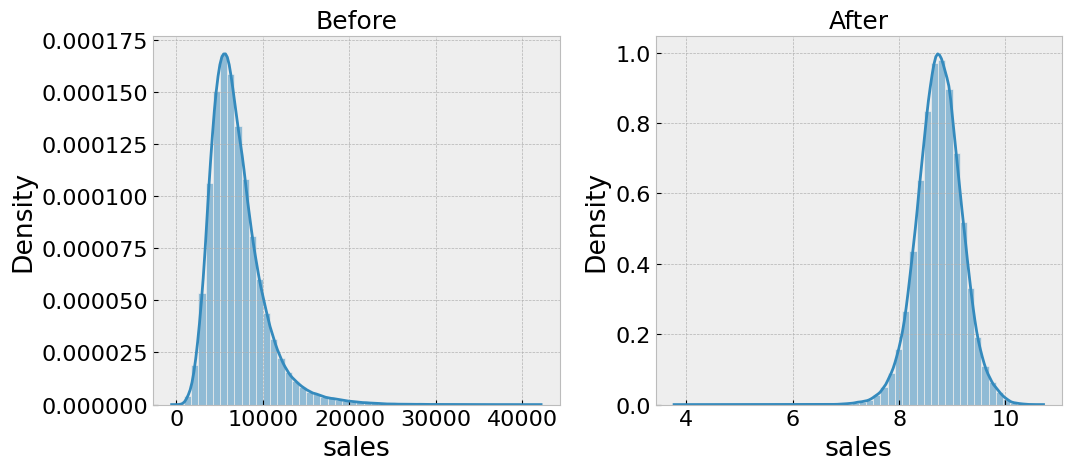

In [ ]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.title('Before', fontsize= 18)
sns.histplot(df4['sales'], **histogram_args)

plt.subplot(1,2,2)
plt.title('After', fontsize= 18)
sns.histplot(df5['sales'], **histogram_args)

plt.tight_layout()

### 5.3.3 Nature transformation

In [ ]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2*np.pi / 12) ))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2*np.pi / 12) ))

# day 
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2*np.pi / 30) ))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2*np.pi / 30) ))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi / 52) ))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi / 52) ))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2*np.pi / 7) ))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2*np.pi / 7) ))

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy() # Just creating a copy of df5 to another variable to keep it safe and trackble. Can be ignored.

In [ ]:
# Dropping redundant columns that result from feature engineering 
cols_drop = ['day_of_week', 'week_of_year', 'year_week', 'day', 'month', 'promo_since', 'competition_since']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Spliting dataframe into Train-Test

 In this case, the split will be such that the training dataset includes all rows from the first recorded date to six weeks prior to the last recorded date. The test split will consist of the remaining data up to the actual last date. 

In [ ]:
# Versão do curso, remover posteriormente
#df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta()

In [ ]:
df6['date'].max() - datetime.timedelta(weeks = 6)

# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


In [ ]:
print('Min Train date {}'.format(X_train['date'].min()))
print('Max Train date {}'.format(X_train['date'].max()))

print('\nMin Test date {}'.format(X_test['date'].min()))
print('Max Test date {}'.format(X_test['date'].max()))

Min Train date 2013-01-01 00:00:00
Max Train date 2015-06-18 00:00:00

Min Test date 2015-06-19 00:00:00
Max Test date 2015-07-31 00:00:00


## 6.2 Using Boruta algorithm as feature selector

In [ ]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,False,False,False,True,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [ ]:
# Adjusting dataframes for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define Random Forest for boruta
#rf = RandomForestRegressor(n_jobs = -1)

# Definition and fiting Boruta algorithm
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [ ]:
#cols_selected = boruta.support_.tolist()

# Best features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Features not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [ ]:
#cols_selected_boruta

In [ ]:
#cols_not_selected_boruta

### 6.2.1 Manual Selection

In [ ]:
# Saving boruta results plus adding to boruta selection the columns ['month_sin', 'week_of_year_sin'] to complement the cossine counterparts that was included.
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin',
     'day_of_week_sin',
     'day_of_week_cos']

# Keeping track of the columns that Boruta algorithm don't choose.
cols_not_selected_boruta = [
     'is_promo',
     'month_sin',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter_holiday',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'week_of_year_sin', 
     'year']

# We will need to use this columns later
cols_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(cols_to_add)

# 7.0 Machine Learning Modeling

In [ ]:
# Selecting the relevant columns suggested by Boruta on the train/test splits. 
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Linear Models (Single training)

### 7.1.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# Performance
baseline_results = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_results


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,36.807613


### 7.1.2 Linear Regression Model

In [ ]:
# Model
lr = LinearRegression()

# Fit / Predict
yhat_lr = lr.fit(x_train, y_train).predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,43.209834


### 7.1.3 Linear Regression Regularized (Lasso)

In [ ]:
# Model
lr_lasso = Lasso(alpha=0.01)

# Fit / Predict
yhat_lr_lasso = lr_lasso.fit(x_train, y_train).predict(x_test)

# Performance
lasso_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lr_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,43.493734


### 7.1.4 Results

Single results using only one split, train and test. This results are for performance comparition only and don't represent the true performance of the models. 

In [ ]:
linear_models = pd.concat([baseline_results, lr_result, lasso_result]).set_index('Model Name').sort_values(by='RMSE')
linear_models

,MAE,MAPE,RMSE
Model Name,,,
Average Model,1354.800353,0.455051,36.807613
Linear Regression,1867.089774,0.292694,43.209834
Linear Regression - Lasso,1891.704880,0.289106,43.493734


## 7.2 Non Linear Models (Single training)

### 7.2.1 Random Forest Regressor

In [ ]:
# #Model definition
# rf = RandomForestRegressor(n_estimators=100,
#                            max_depth=20,
#                            n_jobs=-1,
#                            random_state=42)

# # Fit / Predict
# yhat_rf = rf.fit(x_train, y_train).predict(x_test)

# # Performance
# rf_results = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))

In [ ]:
# rf_results

### 7.2.2 XGBoost Regressor

In [ ]:
# Model definition
# xgb = XGBRegressor(objective='reg:squarederror',
#                     n_estimators=100,
#                     eta=0.1,
#                     max_depth=10,
#                     subsample=0.7,
#                     colsample_bytree=0.9)

# # Fit / Predict
# yhat_xgb = xgb.fit(x_train, y_train).predict(x_test)

# # Performance
# xgb_results = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_xgb))

### 7.2.3 Results

Single results using only one split, train and test. This results are for performance comparition only and don't represent the true performance of the models. 

In [ ]:
# nonlinear_models = pd.concat([rf_results, xgb_results]).set_index('Model Name').sort_values(by='RMSE')
# nonlinear_models

## 7.3 Cross Validation

In the sections above we trained the models with a single train / test split in the dataframe, but we need to change it to get more robust results. So we'll use cross validation to make multiple train / test splits. Notice that we'll spliting with respect to the dates that's in the dataframe. So as mentioned before, we are using a moving time window of 6 weeks prior the last recorded date. To do this we're implementig the cross_val function.

In [ ]:
# Selecting the dataframe necessary to the training
x_training = X_train[cols_selected_boruta_full]

In [ ]:
# Defining all models tha we'll be using
# lr = LinearRegression()

# lasso = Lasso(alpha=0.01)

# rf = RandomForestRegressor(n_estimators=100,
#                            max_depth=20,
#                            n_jobs=-1,
#                            random_state=42)

# xgb = XGBRegressor(objective='reg:squarederror',
#                     n_estimators=100,
#                     eta=0.1,
#                     max_depth=10,
#                     subsample=0.7,
#                     colsample_bytree=0.9)

# Creating model list
# model_list = [lr, lasso, rf, xgb]

# Setting list comprehension and concat the results in a pandas dataframe format.
# cross_val_list = [cross_val(m, kfold=5, x_training=x_training) for m in model_list] 
# cross_val_df = pd.concat(cross_val_list, axis=0, ignore_index=True).sort_values(by='RMSE_CV')

In [ ]:
# cross_val_df

In [ ]:
# rf_teste = RandomForestRegressor(n_estimators=200,
#                            max_depth=20,
#                            n_jobs=-1,
#                            min_samples_leaf=500)

# rf_teste_results = cross_val(rf_teste, kfold=5, x_training=x_training)
# rf_teste_results

# 8.0 Fine Tuning

We'll be implementing the Bayesian Search for finding the best parameters for both models.

In [ ]:
# Adjusting dataset for the fine tuning processes

x_train_ft = x_training.drop(columns=['sales'])
dates = x_train_ft['date'].reset_index(drop=True)

## 8.1 Bayes Search

### Bayes search for XGB Regressor:

In [ ]:
# xgb_search = {
#     'eta': space.Real(0.3, 1, prior='uniform'),
#     'learning_rate': space.Real(1e-3, 0.3, prior='log-uniform'),
#     'max_depth': space.Integer(6, 30),
#     'subsample': space.Real(0.1, 0.7, prior='uniform'),
#     'colsample_bytree': space.Real(0.3, 1, prior='uniform'),
#     'min_child_weight': space.Integer(1, 20),
#     'reg_lambda': space.Real(1e-3, 10.0, 'log-uniform'),
#     'reg_alpha': space.Real(1e-3, 10.0, 'log-uniform')
# }

# Setting a custom cross validation generator
# cv_time_splitter = TimeSeriesWindowSplit(n_splits=5, window_weeks=6)

In [ ]:
# xgb_ES = XGBWithEarlyStopping(objective='reg:squarederror',
#                               n_estimators=1000,
#                               tree_method='hist',
#                               n_jobs=1)

# # Bayes search fit for XGB Regressor (code is commented to avoid long runtime, best params already calculated)
# bayes_opt = BayesSearchCV(estimator=xgb_ES,
#                           search_spaces=xgb_search,
#                           cv=cv_time_splitter,
#                           n_iter=10,
#                           n_jobs=1,
#                           verbose=2)

# bayes_opt.fit(x_train_ft.drop(columns=['date']), y_train, groups=dates)

In [ ]:
# Bayesian search best params for XGB Regressor
# xgb_best_params = bayes_opt.best_params_
# xgb_best_params

In [ ]:
# Saving best parameters for future usage 
# best_params_xgb = [('colsample_bytree', 0.6093494625158796),
#              ('eta', 0.5753399462944516),
#              ('learning_rate', 0.0775566195582778),
#              ('max_depth', 9),
#              ('min_child_weight', 13),
#              ('reg_alpha', 4.943144879193704),
#              ('reg_lambda', 0.37164138852064893),
#              ('subsample', 0.5559779396013314)]

# xgb_params_dict = dict(best_params_xgb)

### Bayes search for Random Forest Regressor:

# 8.2 Final Models (tuned)

## Final XGB Regressor model

In [ ]:
# # Spliting the train dataset for validation
# x_tr, x_val, y_tr, y_val = train_test_split(x_training, y_train, test_size= 0.2, shuffle=False) 

# #Model definition
# final_xgb = XGBRegressor(**xgb_params_dict, 
#                              objective='reg:squarederror',
#                              n_estimators=2000,
#                              tree_method='hist',
#                              n_jobs=1)

# # Fit / Predict
# xgb_tuned = final_xgb.fit(x_tr.drop(columns=['sales', 'date']), y_tr,    
#                         eval_set=[(x_val.drop(columns=['sales', 'date']), y_val)],  
#                         eval_metric="rmse",         
#                         early_stopping_rounds=100,  
#                         verbose=False)

# yhat_xgb = xgb_tuned.predict(x_test)

# # Performance
# tuned_xgb_results = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# tuned_xgb_results

In [ ]:
# First run results: 
# - Optimized number of estimators: 1979 
# - Optimized number of trees: 1980

# best_estimators = xgb_tuned.best_iteration
# best_ntrees = xgb_tuned.best_ntree_limit

# print(f"Optimized number of estimators: {best_estimators} \nOptimized number of trees: {best_ntrees}")

In [ ]:
# Saving final model
# xgb_tuned.save_model("xgb_rossman.json")

In [ ]:
# Loading final model 
xgb_load = XGBRegressor()
xgb_load.load_model("xgb_rossman.json")

yhat_xgb = xgb_load.predict(x_test)

# Performance
xgb_perf = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_perf

,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,645.352428,0.093618,25.403788


In [ ]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb))
mpe

0.003994578592460317

## Final Random Forest Regressor model

In [ ]:
# rf_tuned = RandomForestRegressor(n_estimators=365,
#                                  max_depth= 44,
#                                  min_samples_leaf = 171,
#                                  n_jobs=-1)

# yhat_rf_tuned = rf_tuned.fit(X_train_ft.drop(columns=['date']), y_train_ft).predict(X_val.drop(columns=['date']))

# # Performance
# rf_tuned_result = ml_error("Random Forest Tuned", np.expm1(y_val), np.expm1(yhat_rf_tuned))
# rf_tuned_result

# 9.0 Error Interpretation

In [ ]:
df9 = X_test[cols_selected_boruta_full].copy()

# Rescaling ['sales'] column
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb)

## 9.1. Businesse Performance

In [ ]:
# Sum of predictions
df9_sum = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
# df9_aux1 = df9['store', 'sales', 'predictions'].groupby('store').apply( lambda x: mean_absolute_error())


## 9.2. Total Performance

## 9.3. Machine Learning Performance